**Simplistic DCF Analysis**

The value of the company is $416.90.


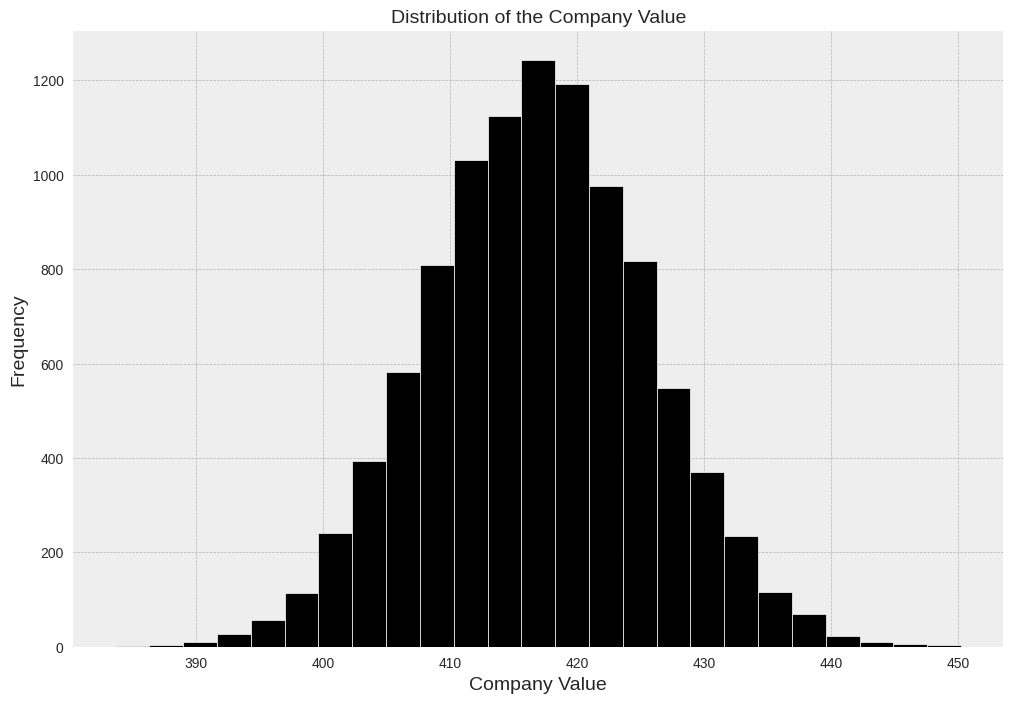

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import font_manager

num_scenarios = 1e4
forecast_period = 5 #years
required_rate_of_return = 0.1
initial_free_cash_flow_to_equity = 100

growth_of_free_cash_flow_to_equity = 0.1 # this is merely an assumption
standard_deviation_of_growth_of_free_cash_flow_to_equity = 0.05 # this is merely an assumption
future_fcfe = initial_free_cash_flow_to_equity * (1 + np.random.normal(growth_of_free_cash_flow_to_equity, standard_deviation_of_growth_of_free_cash_flow_to_equity, size = (int(num_scenarios), forecast_period)))
present_values = []

for scenario in future_fcfe:
    present_value = 0
    for i, fcfe in enumerate(scenario):
        present_value += fcfe / (1 + required_rate_of_return) ** (i + 1)
    present_values.append(present_value)

company_value = np.mean(present_values)
print(f"The value of the company is ${company_value:,.2f}.")

font = font_manager.FontProperties( size = 14)
plt.style.use('bmh')
fig, ax = plt.subplots(figsize = (12,8))
ax.hist(present_values, bins = 25, color = '#000000', edgecolor = 'white')

ax.set_title("Distribution of the Company Value", fontproperties = font)
ax.set_xlabel("Company Value", fontproperties = font)
ax.set_ylabel("Frequency", fontproperties = font)

plt.show()

**More Comprehensive DCF Analysis**

In [36]:
years = ['2020A', '2021B', '2022P', '2023P', '2024P', '2025P']
sales = pd.Series(index = years)
sales['2020A'] = 31
sales

2020A    31.0
2021B     NaN
2022P     NaN
2023P     NaN
2024P     NaN
2025P     NaN
dtype: float64

In [37]:
growth_rate = 0.1
for year in range(1,6):
  sales[year] = sales[year-1]*(1+growth_rate)
sales

2020A    31.00000
2021B    34.10000
2022P    37.51000
2023P    41.26100
2024P    45.38710
2025P    49.92581
dtype: float64

In [38]:
ebidta_margin = 0.14
depr_percent = 0.032
ebidta = sales*ebidta_margin
depreciation = sales*depr_percent
ebit = ebidta - depreciation
new_percent = 0.24
nwc = sales*new_percent
change_in_nwc = nwc.shift(1) - nwc
capex_percent = depr_percent
capex = -sales*capex_percent
tax_rate = 0.25
tax_payment = -ebit*tax_rate
tax_payment = tax_payment.apply(lambda x: min(x,0))
free_cash_flow = ebit + depreciation + tax_payment + capex + change_in_nwc
free_cash_flow

2020A         NaN
2021B    2.018100
2022P    2.219910
2023P    2.441901
2024P    2.686091
2025P    2.954700
dtype: float64

In [39]:
cost_of_capital = 0.12
terminal_growth = 0.02
terminal_value = ((free_cash_flow[-1]*(1+terminal_growth))/(cost_of_capital - terminal_growth))

discount_factors = [(1/(1+cost_of_capital))**i for i in range(1,6)]

dcf_value = (sum(free_cash_flow[1:]*discount_factors) + terminal_value*discount_factors[-1])


In [40]:
output = pd.DataFrame([sales, ebit, free_cash_flow], index = ['Sales', 'EBIT', 'Free Cash Flow']).round(3)

output

,2020A,2021B,2022P,2023P,2024P,2025P
Sales,31.000,34.100,37.510,41.261,45.387,49.926
EBIT,3.348,3.683,4.051,4.456,4.902,5.392
Free Cash Flow,NaN,2.018,2.220,2.442,2.686,2.955


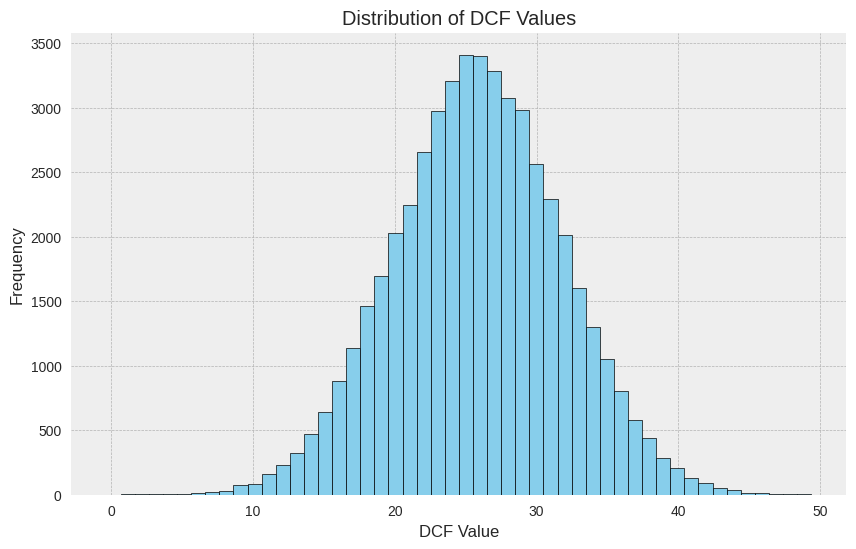

In [41]:
iterations = 1e4
def run_monte_carlo():
  sales_growth_dist = np.random.normal(loc = 0.1, scale = 0.01, size = int(iterations))
  ebidta_margin_dist = np.random.normal(loc = 0.14, scale = 0.02, size = int(iterations))
  nwc_percent_dist = np.random.normal(loc = 0.24, scale = 0.01, size = int(iterations))

  output_distributions = []
  for i in range(int(iterations)):
    for year in range(1,6):
      sales[year] = sales[year - 1]*(1 + sales_growth_dist[i])
      ebidta[year] = sales[year]*ebidta_margin_dist[i]
      depreciation = sales*depr_percent
      ebit = ebidta - depreciation
      nwc = sales*nwc_percent_dist[i]
      change_in_nwc = nwc.shift(1) - nwc
      capex = -sales*capex_percent
      tax_payment = -ebit*tax_rate
      tax_payment = tax_payment.apply(lambda x: min(x,0))
      free_cash_flow = ebit + depreciation + tax_payment + capex + change_in_nwc

      terminal_value = (free_cash_flow[-1]*1.02)/(cost_of_capital - 0.02)
      free_cash_flow[-1]+=terminal_value
      discount_factors = [(1/(1+cost_of_capital))**i for i in range(1,6)]
      dcf_value = (sum(free_cash_flow[1:]*discount_factors))
      output_distributions.append(dcf_value)
  return output_distributions
output_distributions = run_monte_carlo()

plt.figure(figsize=(10, 6))
plt.hist(output_distributions, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of DCF Values')
plt.xlabel('DCF Value')
plt.ylabel('Frequency')
plt.show()


**DCF with Sensitivity Analysis on Synthetic Data**

In [42]:
#Get synthetic data from Gemini

# Re-create the previous dataframe for consistency
data = {
    "Year": [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
    "totalAssets": [2416.93, 5849.25, 8092.46, 22664.08, 28655.37, 29739.61, 34309.00, 52148.00, 62131.00, 82338.00],
    "totalLiab": [1749.81, 4937.54, 7003.52, 16758.95, 23023.05, 23426.01, 26199.00, 28469.00, 31116.00, 36440.00],
    "inventory": [340.36, 953.67, 1277.84, 2067.45, 2263.54, 3113.45, 3552.00, 4101.00, 5757.00, 12839.00],
    "cash": [845.89, 1887.77, 1174.28, 3393.22, 3367.91, 3685.62, 6268.00, 19384.00, 17576.00, 16253.00],
    "propertyPlantEquipment": [1120.92, 1829.27, 3403.33, 15036.92, 20491.62, 19691.00, 20199.00, 12747.00, 31176.00, 36635.00],
    "accountsPayable": [412.22, 1046.83, 1338.94, 1860.34, 2390.25, 3404.45, 3771.00, 6051.00, 10025.00, 15255.00]
}

df = pd.DataFrame(data)

# Generate random but similar values for years 2000-2012
np.random.seed(42)  # For reproducibility

years = list(range(2000, 2013))
new_data = {
    "Year": years,
    "totalAssets": np.random.uniform(2000, 6000, len(years)).tolist(),
    "totalLiab": np.random.uniform(1000, 5000, len(years)).tolist(),
    "inventory": np.random.uniform(200, 1200, len(years)).tolist(),
    "cash": np.random.uniform(500, 2000, len(years)).tolist(),
    "propertyPlantEquipment": np.random.uniform(1000, 3000, len(years)).tolist(),
    "accountsPayable": np.random.uniform(300, 1500, len(years)).tolist()
}

new_df = pd.DataFrame(new_data)

# Combine the new data with the original dataframe
final_df = pd.concat([new_df, df]).reset_index(drop=True)

# Generate random but reasonable values for additional columns for all years (2000-2022)
additional_data = {
    "totalRevenue": np.random.uniform(3000, 15000, len(final_df)).tolist(),
    "netWorkingCapital": np.random.uniform(500, 5000, len(final_df)).tolist(),
    "ebit": np.random.uniform(200, 8000, len(final_df)).tolist(),
    "depreciationAndAmortization": np.random.uniform(100, 1500, len(final_df)).tolist(),
    "capitalExpenditure": np.random.uniform(200, 2000, len(final_df)).tolist(),
    "tax_provision": np.random.uniform(50, 1000, len(final_df)).tolist()
}

# Add these new columns to the existing dataframe
for column, values in additional_data.items():
    final_df[column] = values

print(final_df)


    Year   totalAssets     totalLiab     inventory          cash  \
0   2000   3498.160475   1849.356443    399.673782   1160.228741   
1   2001   5802.857226   1727.299869    714.234438    683.057352   
2   2002   4927.975767   1733.618039    792.414569   1242.765365   
3   2003   4394.633937   2216.968972    246.450413    551.582782   
4   2004   2624.074562   3099.025727    807.544852   1863.980603   
5   2005   2623.978081   2727.780075    370.524124    888.169972   
6   2006   2232.334449   2164.916561    265.051593   1493.783427   
7   2007   5464.704583   3447.411579   1148.885537    967.566614   
8   2008   4404.460047   1557.975443   1165.632033   1280.102032   
9   2009   4832.290311   2168.578594   1008.397348   1320.065419   
10  2010   2082.337977   2465.447373    504.613769    777.281683   
11  2011   5879.639409   2824.279937    297.672114   1954.376942   
12  2012   5329.770563   4140.703846    884.233027   1662.699235   
13  2013   2416.930000   1749.810000    340.3600

In [43]:
df = final_df.copy()

df["revenueGrowth"] = df["totalRevenue"].pct_change()
df["delta_nwc"] = df["netWorkingCapital"].diff()
df["ebit_of_sales"] = df["ebit"]/df["totalRevenue"]
df["depreciationAndAmortization_of_sales"] = df["depreciationAndAmortization"]/df["totalRevenue"]
df["capital_expenditure_of_sales"] = df["capitalExpenditure"]/df["totalRevenue"]
df["nwc_of_sales"] = df["delta_nwc"]/df["totalRevenue"]
df["tax_of_ebit"] = df["tax_provision"]/df["ebit"]
df["ebiat"] = df["ebit"] - df["tax_provision"]

last_year = df.iloc[-1,:]


In [44]:
df

,Year,totalAssets,totalLiab,inventory,cash,propertyPlantEquipment,accountsPayable,totalRevenue,netWorkingCapital,ebit,...,capitalExpenditure,tax_provision,revenueGrowth,delta_nwc,ebit_of_sales,depreciationAndAmortization_of_sales,capital_expenditure_of_sales,nwc_of_sales,tax_of_ebit,ebiat
0,2000,3498.160475,1849.356443,399.673782,1160.228741,2878.997883,951.235300,7301.588743,3363.846851,1977.894268,...,1419.615851,651.446384,NaN,NaN,0.270885,0.110079,0.194426,NaN,0.329364,1326.447883
1,2001,5802.857226,1727.299869,714.234438,683.057352,2789.654701,469.109070,4390.428714,1914.601915,3531.440751,...,229.858092,372.078301,-0.398702,-1449.244936,0.804350,0.039192,0.052354,-0.330092,0.105362,3159.362450
2,2002,4927.975767,1733.618039,792.414569,1242.765365,2195.799958,1262.636377,13357.241111,2788.568110,6580.515174,...,1121.767505,381.749096,2.042355,873.966195,0.492655,0.036692,0.083982,0.065430,0.058012,6198.766078
3,2003,4394.633937,2216.968972,246.450413,551.582782,2843.748470,389.460772,10479.577522,4584.049133,6913.698549,...,607.692395,739.657895,-0.215438,1795.481022,0.659731,0.130880,0.057988,0.171331,0.106984,6174.040654
4,2004,2624.074562,3099.025727,807.544852,1863.980603,1176.985004,1484.264324,6970.776298,1621.815031,254.226618,...,1361.311023,902.254747,-0.334823,-2962.234101,0.036470,0.062459,0.195288,-0.424950,3.549018,-648.028129
5,2005,2623.978081,2727.780075,370.524124,888.169972,1391.965725,1226.693723,3762.700203,2346.723154,4183.828960,...,513.859572,892.732103,-0.460218,724.908122,1.111922,0.080488,0.136567,0.192656,0.213377,3291.096857
6,2006,2232.334449,2164.916561,265.051593,1493.783427,1090.454578,538.458818,6731.787861,3899.980123,3455.805825,...,1443.687929,790.881769,0.789084,1553.256970,0.513356,0.116646,0.214458,0.230735,0.228856,2664.924056
7,2007,5464.704583,3447.411579,1148.885537,967.566614,1650.660662,306.626541,6902.199864,1529.591745,1932.440922,...,896.123623,659.930064,0.025315,-2370.388379,0.279975,0.214411,0.129832,-0.343425,0.341501,1272.510858
8,2008,4404.460047,1557.975443,1165.632033,1280.102032,1777.354579,1278.553714,11755.274140,846.409594,1134.949865,...,1886.113980,129.932967,0.703120,-683.182150,0.096548,0.037335,0.160448,-0.058117,0.114483,1005.016898
9,2009,4832.290311,2168.578594,1008.397348,1320.065419,1542.698064,1148.228813,10650.689656,1803.881538,2833.398337,...,447.537699,203.547278,-0.093965,957.471944,0.266030,0.097739,0.042020,0.089898,0.071839,2629.851059


In [45]:
# assumption of variables
# N = years of projection, usually 5-10
# revGrowth = 7%
# ebit/sales = 23%
# d&a/sales = 3%
# capex/sales = 5%
# delta nwc / sales = 5%
# tax/ebit = 21%
# terminal growth rate = 2.5%


n = 10
revGrowth = 0.07
ebit_perc_sales = 0.23
da_perc_sales = 0.03
capex_perc_sales = 0.05
delta_nwc_perc_sales = 0.05
tax_perc_ebit = 0.21
tgr = 0.025


In [46]:
def interpolate(initial_value, terminal_value, nyears):
  return np.linspace(initial_value, terminal_value, nyears)


In [47]:
years = range(df.index[-1]+1 , df.index[-1] + n + 1) # from the last year in the dataset to n years later for projection
#linear interpolation
df_proj = pd.DataFrame(index = years, columns = df.columns)
df_proj["revenueGrowth"] = interpolate(last_year["revenueGrowth"], revGrowth, n)
df_proj["ebit_of_sales"] = interpolate(last_year["ebit_of_sales"], ebit_perc_sales, n)
df_proj["depreciationAndAmortization_of_sales"] = interpolate(last_year["depreciationAndAmortization_of_sales"], da_perc_sales, n)
df_proj["capital_expenditure_of_sales"] = interpolate(last_year["capital_expenditure_of_sales"], capex_perc_sales, n)
df_proj["nwc_of_sales"] = interpolate(last_year["nwc_of_sales"], delta_nwc_perc_sales, n)
df_proj["tax_of_ebit"] = interpolate(last_year["tax_of_ebit"], tax_perc_ebit, n)

# cumulative values

df_proj["totalRevenue"] = last_year["totalRevenue"]*(1+df_proj["revenueGrowth"]).cumprod()
df_proj["ebit"] = last_year["ebit"]*(1+df_proj["ebit_of_sales"]).cumprod()
df_proj["capitalExpenditure"] = last_year["capitalExpenditure"]*(1+df_proj["capital_expenditure_of_sales"]).cumprod()
df_proj["depreciationAndAmortization"] = last_year["depreciationAndAmortization"]*(1+df_proj["depreciationAndAmortization_of_sales"]).cumprod()
df_proj["delta_nwc"] = last_year["delta_nwc"]*(1+df_proj["nwc_of_sales"]).cumprod()
df_proj["tax_provision"] = last_year["tax_provision"]*(1+df_proj["tax_of_ebit"]).cumprod()
df_proj["ebiat"] = df_proj["ebit"] - df_proj["tax_provision"]



The last step before calculating the Weighted Average Cost of Capital is to calculate the Free Cash Flow as follows :

FCF = EBIAT + D&A - CAPEX - ΔNWC

In [48]:
df_proj["free_cash_flow"] = df_proj["ebiat"] + df_proj["depreciationAndAmortization"] - df_proj["capitalExpenditure"] - df_proj["delta_nwc"]

In [49]:
df_proj["free_cash_flow"]

23    1.098872e+04
24    2.599134e+04
25    5.834096e+04
26    1.221865e+05
27    2.374721e+05
28    4.266126e+05
29    7.050780e+05
30    1.065561e+06
31    1.461143e+06
32    1.800284e+06
Name: free_cash_flow, dtype: float64

**WACC Estimation**

For the calculation of the WACC, we will need the following numbers:

1. Company's Beta
2. Company's Market Capitalization
3. 10-year US Treasury Rate, as a proxy for the risk-free rate
4. Yield-to-Maturity of the company's bonds
5. Equity Risk Premium

We can randomly generate these values and plug it into our synthetic data

According to the Capital Asset Pricing Model, the cost of equity is often calculated as the expected rate of return on the company's equity

We calculate it by the formula

CostOfEquity = risk_free_rate + beta*(return_on_market - risk_free_rate)

The term multiplied by beta is known as the Equity Risk Premium


In [50]:
np.random.seed(42)

beta_range = (0.8, 1.5)
market_cap_range = (1e7, 1e9)  # in dollars
risk_free_rate_range = (0.01, 0.05)
yield_to_maturity_range = (0.03, 0.08)
equity_risk_premium_range = (0.04, 0.08)

# Create a dictionary to store the data
wacc_data = {
    "Year": final_df["Year"].values,
    "Beta": np.random.uniform(beta_range[0], beta_range[1], len(final_df)),
    "MarketCap": np.random.uniform(market_cap_range[0], market_cap_range[1], len(final_df)),
    "RiskFreeRate": np.random.uniform(risk_free_rate_range[0], risk_free_rate_range[1], len(final_df)),
    "YieldToMaturity": np.random.uniform(yield_to_maturity_range[0], yield_to_maturity_range[1], len(final_df)),
    "EquityRiskPremium": np.random.uniform(equity_risk_premium_range[0], equity_risk_premium_range[1], len(final_df))
}

# Create a DataFrame from the dictionary
wacc_df = pd.DataFrame(wacc_data)

# Print the DataFrame
print(wacc_df)


    Year      Beta     MarketCap  RiskFreeRate  YieldToMaturity  \
0   2000  1.062178  3.726982e+08      0.022468         0.079344   
1   2001  1.465500  4.615093e+08      0.030803         0.068612   
2   2002  1.312396  7.873242e+08      0.031868         0.039936   
3   2003  1.219061  2.076770e+08      0.017394         0.030276   
4   2004  0.909213  5.190921e+08      0.048783         0.070773   
5   2005  0.909196  5.964904e+08      0.041005         0.065343   
6   2006  0.840659  5.598591e+07      0.047580         0.066450   
7   2007  1.406323  6.114694e+08      0.045793         0.068564   
8   2008  1.220781  1.788189e+08      0.033916         0.033702   
9   2009  1.295651  7.440108e+07      0.046875         0.047923   
10  2010  0.814409  9.493967e+08      0.013540         0.035793   
11  2011  1.478937  9.659757e+08      0.017839         0.073155   
12  2012  1.382710  8.103134e+08      0.011809         0.061165   
13  2013  0.948637  3.115676e+08      0.023013         0.04654

In [51]:
last_beta = wacc_df["Beta"].iloc[-1]
last_risk_premium = wacc_df["EquityRiskPremium"].iloc[-1]
last_rf_rate = wacc_df["RiskFreeRate"].iloc[-1]

In [52]:
costOfEquity = last_beta*last_risk_premium + last_rf_rate
costOfEquity

0.07861227061365599

We will substitute the yield to maturity as the value for the cost of debt

In [53]:
costOfDebt = wacc_df["YieldToMaturity"].mean()

In [54]:
costOfDebt

0.055240867725141106

In [55]:
assets = last_year["totalAssets"]
debt = last_year["totalLiab"]
total = wacc_df["MarketCap"].iloc[-1] + debt
afterTaxCostofDebt = costOfDebt*(1-tax_perc_ebit)
wacc = afterTaxCostofDebt*(debt/total) + costOfEquity*(wacc_df["MarketCap"].iloc[-1]/total)

In [56]:
def calculate_present_value(cash_flows, discount_rate) :
  present_values_cf = [cf/(1+discount_rate)**t for t, cf in enumerate(cash_flows, start = 1)]
  return (present_values_cf)
df_proj["pv_FCF"] = calculate_present_value(df_proj["free_cash_flow"], wacc)

In [57]:
wacc

0.07861035694039199

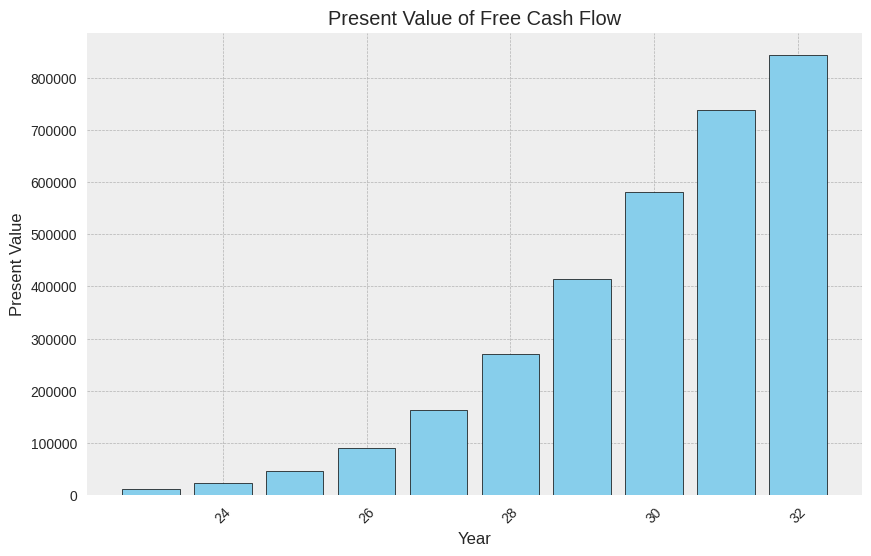

In [58]:
plt.figure(figsize=(10, 6))
plt.bar(df_proj.index, df_proj["pv_FCF"], color='skyblue', edgecolor='black')
plt.title('Present Value of Free Cash Flow')
plt.xlabel('Year')
plt.ylabel('Present Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [59]:
TV = df_proj["free_cash_flow"].values[-1]*(1+tgr)/(wacc-tgr)
pv_TV = TV/(1+wacc)**(n)
pv_TV

16149922.25619974

In [60]:
OutShares = 3186000000

In [61]:
enterprise_value = np.sum(df_proj["pv_FCF"]) + pv_TV
cash = last_year["cash"]
equity_value = enterprise_value - debt + cash
impliedSharePrice = equity_value/OutShares

In [62]:
impliedSharePrice

0.006062002019251094

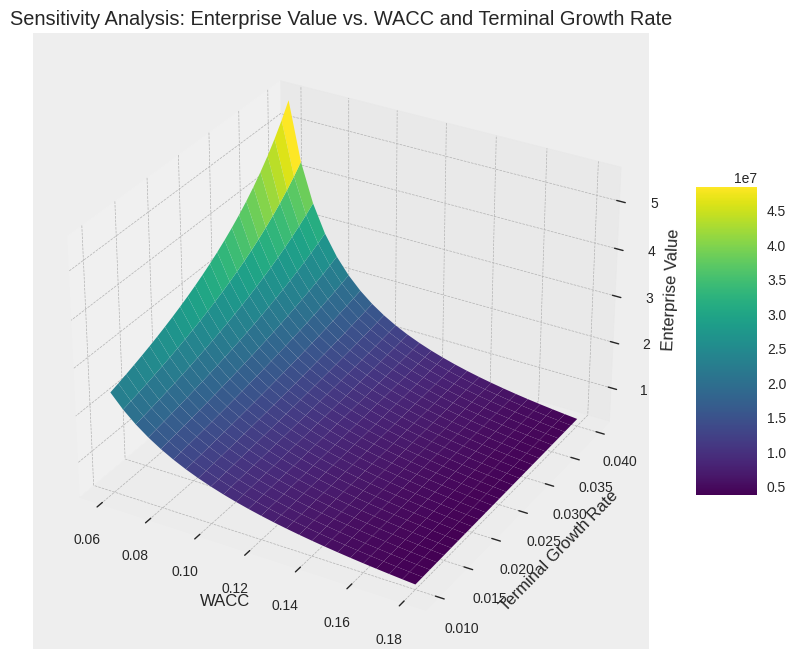

In [63]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

wacc_values = np.linspace(0.06, 0.18, 25)
tgr_values = np.linspace(0.01, 0.04, 25)

wacc_grid, tgr_grid = np.meshgrid(wacc_values, tgr_values)

enterprise_values = np.zeros_like(wacc_grid)

for i in range(len(wacc_values)):
  for j in range(len(tgr_values)):
    wacc = wacc_values[i]
    tgr = tgr_values[j]

    df_proj["pv_FCF"] = calculate_present_value(df_proj["free_cash_flow"], wacc)

    TV = df_proj["free_cash_flow"].values[-1] * (1 + tgr) / (wacc - tgr)
    pv_TV = TV / (1 + wacc) ** (n)

    enterprise_value = np.sum(df_proj["pv_FCF"]) + pv_TV
    enterprise_values[j, i] = enterprise_value

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(wacc_grid, tgr_grid, enterprise_values, cmap=cm.viridis)

ax.set_xlabel('WACC')
ax.set_ylabel('Terminal Growth Rate')
ax.set_zlabel('Enterprise Value')
ax.set_title('Sensitivity Analysis: Enterprise Value vs. WACC and Terminal Growth Rate')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


**DCF Analysis for Merger and Acquisition**

In [64]:
years = 5
starting_sales = 6.6
capex_percent = 0.03
depr_percent = 0.04
sales_growth = 0.09
ebitda_margin = 0.12
nwc_percent = 0.3
tax_rate = 0.25
OutShares = 1.342277 # millions
net_debt = -0.332 #millions
net_cash = 0.134 # millions

r = 0.2
g = 0.015

num_iterations = 1e7
sales_std_dev = 0.05
ebitda_std_dev = 0.01
nwc_std_dev = 0.005



In [65]:
def run_mcs():
  sales_growth_dist = np.random.normal(loc = sales_growth, scale = sales_std_dev, size = (years, int(num_iterations)))
  ebitda_margin_dist = np.random.normal(loc = ebitda_margin, scale = ebitda_std_dev, size = (years, int(num_iterations)))
  nwc_dist = np.random.normal(loc = nwc_percent, scale = nwc_std_dev, size = (years, int(num_iterations)))

  sales_growth_dist += 1
  for i in range(1, len(sales_growth_dist)):
    sales_growth_dist[i] *= sales_growth_dist[i-1]
  sales = sales_growth_dist*starting_sales
  ebitda = sales*ebitda_margin_dist
  ebit = ebitda - sales*depr_percent
  tax = -ebit*tax_rate
  np.clip(tax, a_min = None, a_max = 0)
  starting_nwc = starting_sales*nwc_percent
  nwc = nwc_dist*sales
  prev_year_nwc = np.roll(nwc, 1 , axis = 0)
  prev_year_nwc[0] = starting_nwc
  change_in_nwc = -nwc + prev_year_nwc
  capex  = -sales*capex_percent
  free_cash_flow = ebitda + tax + change_in_nwc + capex


  # now discount values

  terminal_value = free_cash_flow[-1]*(1+g)/(r-g)
  discount_rates = [(1/(1+r))**i for i in range(1, years+1)]
  dcf_values = sum((free_cash_flow.T*discount_rates).T)
  total_free_cash_flow = sum(free_cash_flow)

  print(dcf_values)
  return dcf_values

In [66]:
sims = run_mcs()
print(type(sims))

worst = sims.min()
avg = sims.mean()
best = sims.max()
std_dev = sims.std()

one_std_dev_above = avg + std_dev
two_std_dev_above = avg + 2*std_dev
one_std_dev_below = avg - std_dev
two_std_dev_below = avg - 2*std_dev

[1.20827295 1.25598911 0.96569997 ... 1.00791324 1.01069067 1.28063394]
<class 'numpy.ndarray'>


In [67]:
print(best)

1.7304565112164023


<ipython-input-68-e2067592a2f0>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


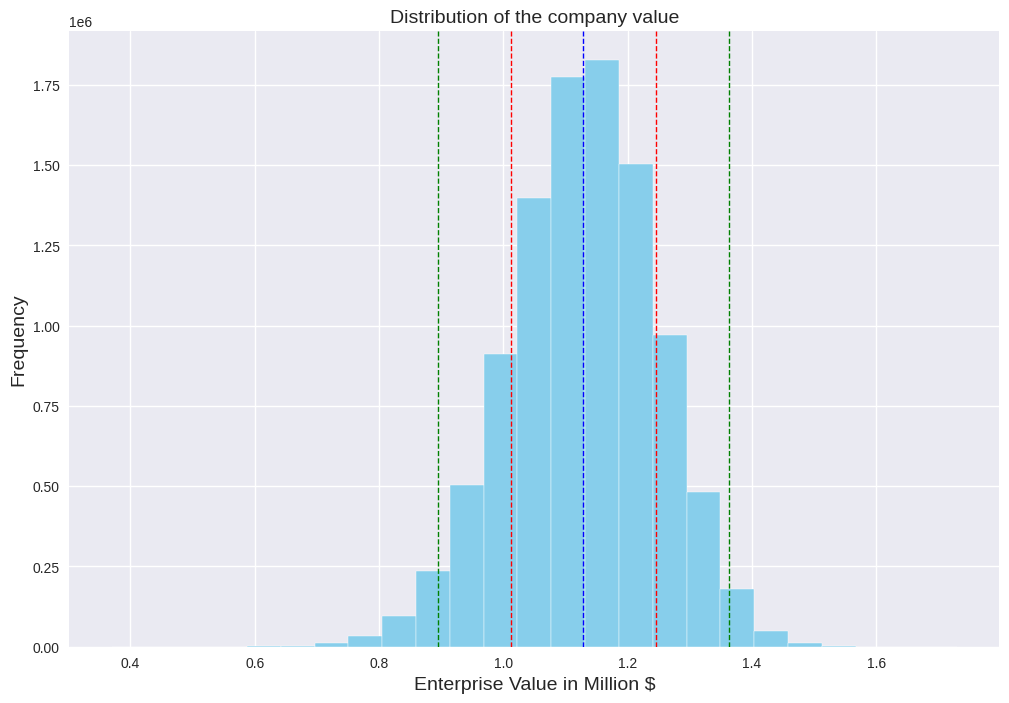

0.693569389890844


In [68]:
font = font_manager.FontProperties(size = 14)
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize = (12,8))
ax.hist(sims, bins = 25, color = 'skyblue', edgecolor = 'white')

ax.set_title("Distribution of the company value", fontproperties = font)
ax.set_xlabel(f"Enterprise Value in Million $", fontproperties = font)
ax.set_ylabel("Frequency", fontproperties = font)

ax.axvline(avg, color = 'b', linestyle = 'dashed', linewidth = 1)
ax.annotate(round(avg, 2), xy = (avg - 3, 14000), fontsize = 17, color = 'r')
ax.axvline(one_std_dev_above, color = 'r', linestyle = 'dashed', linewidth = 1)
ax.axvline(one_std_dev_below, color = 'r', linestyle = 'dashed', linewidth = 1)
ax.axvline(two_std_dev_above, color = 'g', linestyle = 'dashed', linewidth = 1)
ax.axvline(two_std_dev_below, color = 'g', linestyle = 'dashed', linewidth = 1)

plt.show()

equity_value = avg + net_debt + net_cash
implied_share_price = equity_value/OutShares
print(implied_share_price)



**What Exactly is DCF ?**

If you want to buy or sell a company, or buy or sell the share of a company, you need to know the enterprise value of that firm and by consequence the equity value of that firm

There are a number of things that can affect the value of a company , but we need to focus on a few parameters :

1. How much money it makes ?
2. How fast does it grow ?
3. What costs do the operations entail, including depreciation, taxation, and amortization ?
4. What is the variability of all of these components ?


Let us forget about the components themselves and wonder as to how do we consider the variability amongst these ? This is pretty straight-forward by using Monte-Carlo simulation, the ultimate holy-grail of statistical methods : everything is a Monte-Carlo simulation at the end of the day

We choose random but reasonable values for the factors that affect the valuation of the company , examples being, *revenue growth, margin level, net working capital, capital expenditure, cost of capital* etc

We use these values to ascertain if a company is worth more or less than some amount, what the average valuation is, and how much this valuation can vary

What are the advantages of using the MCS ? We are able to account for the uncertainty and risk of the input variables and to estimate a range of possible values for the target firm


Now, we can get to the finer details of the DCF method

The first step is to estimate the company's future cash flows ; remember the DCF method's primary evaluator is cash flow

We predict future revenues , expenses, and other cash flows :  this is done generally for a period of 5 to 10 years

Then we determine the required rate of return ; investors expect to make a certain amount of money in exchange for taking the risk to invest in the company

This required rate of return reflects this expectation, taking into account the company's risk profile

How do we calculate this ? We use a parameter called β to do that !

We find out what is the risk-free rate : this is the baseline return we will get without taking the slightest of risks

But what if we are taking risk ; then what is the *premium* , in simpler terms, *the extra benefit* , we get by taking risk in the market ? That is , expected return in the market in general - risk free rate , of course !

Now , for our particular stock, is the risk higher than the market in general or lower, or , as a mathematical possibility, equal ? We can find this by regressing the movement of stock price of our stock against the movement of our market exchange ! We compare the volatilities of the movements in our regression and to analyse how they fare against each other, we calculate the coefficient β : if β > 1 , then the stock is more risky than the market, and so on ; it is trivial

This β essentially acts as the slope of a line ; what if β = 0 ? Then there is no risk associated vis-a-vis the market...and how much do we earn ? The risk free rate ! So, the risk free rate acts as the *intercept* of this line, and β**equityRiskPremium* is further added to exemplify the case when risk is non-zero ; this equation simply gives us the expected return , or in financial terms, the cost of equity for the firm : it *must* pay at least this much return to the investors for the latter to take up the risk

This is fine, what then is the cost of debt ? That is calculated by using the yield-to-maturity of the company's bonds : each firm, if it wishes to raise money and not give up stake within the firm, issues bonds in the market, on which it agrees to pay an agreed upon interest , at *maturity* of the bond, which is a date which is agreed upon at the issuing of the bond

This interest rate, which the firm must pay to bond holders, is the *cost* of debt ; pretty straightforward

We use these values to calculate the terminal value of the firm , which we further use to calculate the present value

Discount the future cash flows ; and we then go on to calculate the present value for each of the scenarios and average them out to get a realisitc scenario

We further calculate the terminal value ; which we do by assuming that future cash flows keep on increasing indefinitely into the future and we take the last predicted FCF and discount it to get the terminal value

We further discount the terminal value by growth rate for appropriate number of years and add it to that value generated by FCF in the previous years to get the present value

*Present Value* = Σ*Future Cash Flow*/(1 + *required returns*)ⁱ + *TV*/(1+ *required returns*)ⁿ


This finally gives us the present enterprise value

We remove the debt taken by the firm and the cash it already has to get the equity value , which we divide by the number of outstanding shares to finally get the valuation for the share price !

This , in essence, is the DCF Model using MCS and the subsequent sensitivity analysis on it

